## Pre-processing steps of Kaggle's symbols:

> Kggle's symbol Images has to be processed in the same way as MNIST before training, steps involved in preprocessing are:
- Making a binary image with a black backdrop and white symbols
- Dilating by a 3 * 3 kernel
- Padding the image to 20 X 20 while keeping the aspect ratio
- The picture is padded to a size of 28 * 28 by the center of mass.

#### Importing Required Packages

In [2]:
import cv2
import glob
import os
from PIL import Image
import PIL.ImageOps
import numpy as np
import math
from scipy import ndimage
from PIL import Image
from numpy import array
from matplotlib import pyplot as plt

#### Setting path location of original stored symbols and transformed symbols.

In [2]:
symbol = 'times' # Needs to update this to "+", "-", "," to perform transformation for these symbols as well.
path = 'data_collection/kaggle/'+ symbol + '/*.*'
path_transformed = 'data_collection/kaggle_transformed/'+ symbol
img_number = 1 # starting an iterator for the numbering the images after transformation 

In [3]:
# glob
file_list = glob.glob(path) # It will return a list of file names under this folder
print(file_list[0:10]) # Printing 1st 10 file names contained in the list

['data_collection/kaggle/times\\exp1.jpg', 'data_collection/kaggle/times\\exp10047.jpg', 'data_collection/kaggle/times\\exp1010.jpg', 'data_collection/kaggle/times\\exp10112.jpg', 'data_collection/kaggle/times\\exp10113.jpg', 'data_collection/kaggle/times\\exp10173.jpg', 'data_collection/kaggle/times\\exp10219.jpg', 'data_collection/kaggle/times\\exp10230.jpg', 'data_collection/kaggle/times\\exp1031.jpg', 'data_collection/kaggle/times\\exp10339.jpg']


In [4]:
# Loading each file at a time
img_list = [] # Empty list to store images from the folder.
img_list_transformed = [] # Empty list to store the transformed images

## Reading each symbols from the directory, performing transformations and storing in another directory for training neural network

In [9]:
for file in glob.glob(path): # Iterating through each file
    #print(file)
    
    a = cv2.imread(file,0) # now, each file can be read using openCV as numpy array
    (thresh, a) = cv2.threshold(a,127,255,cv2.THRESH_BINARY_INV) # To invert the white pixels to balck and black to white for symbols images to match mnist format
    img_list.append(a) # created a list of images
    
    pi = pre_process_img(a, 1,1) # calling the function to apply transformations on the symbols data
    img_list_transformed.append(pi) # storing processed and normalized image(1,1,28,28)
    
    pi_reshaped = pi.reshape((28,28))
    cv2.imwrite(path_transformed + "/processed"+ str(img_number)+ ".jpeg", 255*pi_reshaped) # Writing each transforemed image into a folder for training the neural network
    img_number +=1
    

#### Showing the outputs of various steps involved during the preprocessing of the symbols images.

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

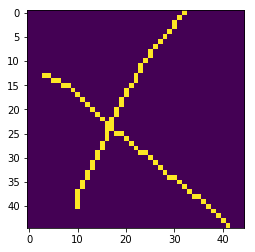

In [31]:
# Plotting the original image read as grayscale format and inverting the pixel colors i,e black pixels to white and vice-versa.
plt.imshow(img_list[5])
img_list[5].shape
img_list[5]

(45, 45)

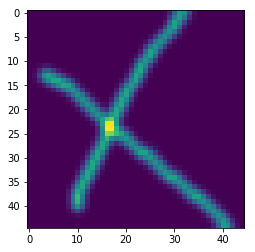

In [33]:
# Applying gaussian blur to smoothen the edges
imagem = cv2.GaussianBlur(img_list[5],(5,5),1)
plt.imshow(imagem)
imagem.shape


In [15]:
# The digit is then placed and centered into a square image by preserving the aspect ratio.

def image_resize(image, width = None, height = None, inter = cv2.INTER_LINEAR):
     '''
    Function description
    image_resize : The objective of the functions is to resize images.
    argument's: This function takes in following input
        image (Matrix)  : source/input image to resize
        width (Integer) : width of the required image 
        height (Integer): height of required image
        inter (Method)  : flag that takes Interpolation/Extrapolation method,
        default is set to INTER_LINEAR(a bilinear interpolation)
    output:
        image (Matrix)  : Returns a resized image
    '''
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)

    # return the resized image
    return resized


(28, 28)

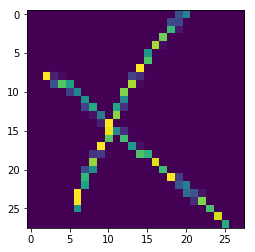

In [16]:
# Resized image
imagem = image_resize(img_list[5], 28, 28, cv2.INTER_CUBIC)
plt.imshow(imagem)
imagem.shape

In [6]:
def obtainBestShift(img):
    '''
    Function Description
    obtainBestShift : This function is used to determine the image's center of mass and obtain the optimal shifts.
    argument:
        img (array) : gray scale image
    output:
        shiftx, shifty: x,y shift direction
    '''
    cy,cx = ndimage.measurements.center_of_mass(img)
    rows,cols = img.shape
    shiftx = np.round(cols/2.0-cx).astype(int)
    shifty = np.round(rows/2.0-cy).astype(int)

    return shiftx,shifty


In [26]:
obtainBestShift(imagem)

(1, -1)

In [7]:
def shift(img,sx,sy):
    '''
    Shift : This function is used to move the image in a specific direction.
    argument:
        img (array) : gray scale image to be shifted
        sx, sy      : x, y direction
    output:
        shifted : shifted image in a specific direction
    '''
    rows,cols = img.shape
    M = np.float32([[1,0,sx],[0,1,sy]])
    shifted = cv2.warpAffine(img,M,(cols,rows))
    return shifted

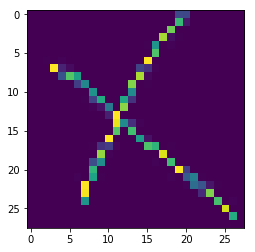

In [24]:
# best shifted image
shift(imagem, 1, -1).shape
plt.imshow(np.reshape(shift(imagem, 1, -1), (28,28)))

In [25]:
def pre_process_img(gray, resize_flag = 1, preproc = 0):
    '''
    Function Description
    pre_process_img  : The objective of this function is to pre process image for prediction
    argument:
        gray (Matrix (np.uint8))  : character image to be resized and processed
        resize_flag               : method used for resizing image
        preproc (method [bool])   : 0 Indictes erosion, Dilation need not be done, 1 indicates Erosion, Dilation needs to be done
    output:
        grayS (Matrix (0-1))      : Image of a character that has been normalized, scaled, and processed
    
    '''    
    gray = gray.copy()
    
    #Image Pre Processing
    if (preproc == 0):
        gray = cv2.GaussianBlur(gray,(7,7),0)
    else :
        kernel = np.ones((3,3), np.uint8)
        gray = cv2.dilate(gray, kernel, iterations=1)    
        gray = cv2.GaussianBlur(gray,(5,5),1)
        gray = cv2.dilate(gray, kernel, iterations=2)
        gray = cv2.erode(gray, kernel,iterations=2)    
    
    #Getting rid of rows and columns when every pixel is black
    while np.sum(gray[0]) == 0:
        gray = gray[1:]

    while np.sum(gray[:,0]) == 0:
        gray = np.delete(gray,0,1)

    while np.sum(gray[-1]) == 0:
        gray = gray[:-1]

    while np.sum(gray[:,-1]) == 0:
        gray = np.delete(gray,-1,1)

    rows,cols = gray.shape
    
    if(resize_flag) == 1:
        interpolation=cv2.INTER_AREA
    else:
        interpolation=cv2.INTER_CUBIC
    # Before resizing, keep the aspect ratio the same.
    if rows > cols:
        factor = 20.0/rows
        rows = 20
        cols = int(round(cols*factor))
        # first cols than rows
        gray = cv2.resize(gray, (cols,rows),interpolation=interpolation)
    else:
        factor = 20.0/cols
        cols = 20
        rows = int(round(rows*factor))
        # first cols than rows
        gray = cv2.resize(gray, (cols, rows),interpolation=interpolation)
   
    # Padding to a 28 * 28 image
    column_padding = (int(math.ceil((28-cols)/2.0)),int(math.floor((28-cols)/2.0)))
    row_padding = (int(math.ceil((28-rows)/2.0)),int(math.floor((28-rows)/2.0)))
    gray = np.lib.pad(gray,(row_padding,column_padding),'constant')
    
    # obtaining the best shifts possible.
    shiftx,shifty = obtainBestShift(gray)
    shifted = shift(gray,shiftx,shifty)
    grayS = shifted
    grayS = grayS.reshape(1,1,28,28)
    
    #Normalizing the image
    grayS = grayS/255
    
    return grayS

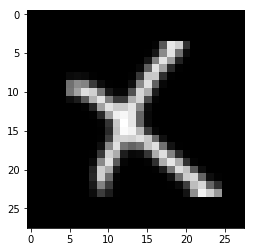

In [29]:
a = pre_process_img(img_list[5], 1,1)
a1 = np.reshape(a, (28,28))
b = plt.imshow(a1, "gray")


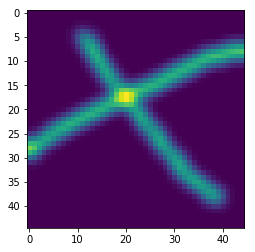

In [7]:
a = cv2.imread('data_collection/kaggle/times\\exp1.jpg',0) # now, each file can be read using openCV as numpy array
(thresh, a) = cv2.threshold(a,127,255,cv2.THRESH_BINARY_INV) # To invert the white pixels to balck and black to white for symbols images to match mnist format


gray = cv2.GaussianBlur(a,(7,7),0)
plt.imshow(gray)

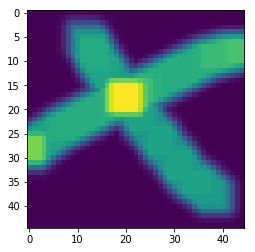

In [9]:
kernel = np.ones((3,3), np.uint8)
gray = cv2.dilate(gray, kernel, iterations=1) 
plt.imshow(gray)

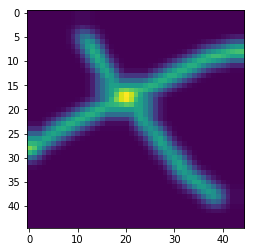

In [10]:
gray = cv2.erode(gray, kernel,iterations=2)
plt.imshow(gray)